<a href="https://colab.research.google.com/github/Justin-Jonany/SciDigest/blob/main/3_scidigest_model_training_200k_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SciDigest**
With the growth of many fields, more papers are published annually. Researchers need to find sources for their research, so abstracts are really helpful. However, reading through hundreds of unstructured abstracts is time-consuming and irritating.

**SciDigest** is a deep learning model that aims to help people, especially researchers, to digest abstracts better. This model receives abstracts as inputs and turn it into a structured abstract.

**SciDigest** will be trained on [PubMed 200k and 20k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct).

Some of the model architecture will be referenced and based on:
* [Paper 1](https://arxiv.org/pdf/1710.06071.pdf)
* [Paper 2](https://arxiv.org/pdf/1612.05251.pdf)

**Note:**
Through this notebook and other notebooks, these papers will be referred as **[Paper 1](https://arxiv.org/pdf/1710.06071.pdf)** and **[Paper 2](https://arxiv.org/pdf/1612.05251.pdf)**

## Goal
The goal of this project:
1. Replicate the model architecture in **Paper 2**
2. Beat the F1-Score of the model in **Paper 1**, that is **91.6**


## Notebook Goal
This notebook aims to:
1. Create the model to fulfill **Goal 2** with the replicated model in notebook 2 with the same model or improved model

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import string

## Helper Function

In [ ]:
def get_data(data_path, data, data_types, to_list=False):
  '''
  Returns a list of dataframes from the directory data_path + data for all
  types of data (train/val/test) listed in data_types. If to_list is True,
  it will be returned as a list, otherwise it's a DataFrame.
  '''

  if to_list:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0)['0'].tolist() for data_type in data_types]
  else:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0) for data_type in data_types]

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def predict_data(model, data):
  '''
  Predicts data with model and returns the predicted class

  Args:
    model: a machine learning model
    data: batched dataset
  Returns:
    prediction: predicted class
  '''
  prediction = model.predict(data, verbose=0)
  prediction = tf.argmax(prediction, axis=1)
  return prediction

## Loading Data

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/data'
datas = os.listdir(data_path)
datas

['general',
 'sentences',
 'sentences_chars',
 'ohe_labels',
 'le_labels',
 'line_numbers',
 'total_lines',
 'general_200k',
 'sentences_200k',
 'sentences_chars_200k',
 'le_labels_200k',
 'line_numbers_200k',
 'total_lines_200k',
 'ohe_labels_200k']

In [ ]:
data_types = ['train', 'val']

In [ ]:
general_20k = get_data(data_path, 'general', data_types)
sentences_20k = get_data(data_path, 'sentences', data_types, to_list=True)
sentences_chars_20k = get_data(data_path, 'sentences_chars', data_types)
ohe_labels_20k = get_data(data_path, 'ohe_labels', data_types)
le_labels_20k = get_data(data_path, 'le_labels', data_types, to_list=True)
line_numbers_20k = get_data(data_path, 'line_numbers', data_types)
total_lines_20k = get_data(data_path, 'total_lines', data_types)

In [ ]:
general_200k = get_data(data_path, 'general_200k', data_types)
sentences_200k = get_data(data_path, 'sentences_200k', data_types, to_list=True)
sentences_chars_200k = get_data(data_path, 'sentences_chars_200k', data_types)
ohe_labels_200k = get_data(data_path, 'ohe_labels_200k', data_types)
le_labels_200k = get_data(data_path, 'le_labels_200k', data_types, to_list=True)
line_numbers_200k = get_data(data_path, 'line_numbers_200k', data_types)
total_lines_200k = get_data(data_path, 'total_lines_200k', data_types)

In [ ]:
TRAIN = 0 # index of the train data
VAL = 1 # index of the validation data

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/models/'

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(general_200k[TRAIN].target.unique())
class_names = general_200k[TRAIN].target.unique()

num_classes, class_names

(5,
 array(['BACKGROUND', 'METHODS', 'CONCLUSIONS', 'RESULTS', 'OBJECTIVE'],
       dtype=object))

## Model 7: Model 6 (from notebook 2) but with leaky Relu

Look at notebook 2 for explainations

In [ ]:
model_6 = tf.keras.models.load_model(MODEL_PATH + 'model_6')

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1-kpceMqkkFgVM9GtuDhTMcLSy9LmeKfY/preview" width="640" height="480" allow="autoplay"></iframe>

### Preparing Datasets

In [ ]:
# Create training datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_20k[0],
                                                                total_lines_20k[0],
                                                                sentences_20k[0],
                                                                sentences_chars_20k[0]
                                                                ))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels_20k[0])
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

# Create validation datasets (with all four kinds of input data)
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_20k[1],
                                                              total_lines_20k[1],
                                                              sentences_20k[1],
                                                              sentences_chars_20k[1]
                                                              ))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels_20k[1])
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
# from notebook 2
max_tokens = 68000
output_len = 172

### Creating Another Text Vectorization Layer

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                            output_mode='int',
                                            output_sequence_length=output_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(sentences_20k[TRAIN])

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f"Most common woords in the vocav: {rct_20k_text_vocab[:5]}")
print(f"Least common woords in the vocav: {rct_20k_text_vocab[:-5]}")

Number of words in vocab: 64841
Most common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of']
Least common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased',

### Creating Text Embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim=256,
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

### Creating Character Tokenizer

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (`[UNK]`)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                          output_sequence_length=output_len,
                                          # standardize=None, # set standardization to `None` to include punctuations
                                          name='char_vectorizer'
                                          )

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(sentences_chars_20k[TRAIN])

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating Character-Level Embedding

In [ ]:
PAPER_2_EMBEDDING_CHAR_DIM = 25 # From Paper 2 Figure 1

char_embed = layers.Embedding(input_dim=len(char_vocab), # Number of different characters
                              output_dim=PAPER_2_EMBEDDING_CHAR_DIM,
                              mask_zero=True,
                              name='char_embed'
                              )

### Creating, Compiling, and Fitting Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype='string', name='token_inputs')
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) # create embedding
token_outputs = layers.Dense(256, activation=tf.keras.layers.LeakyReLU())(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), # 15 since each input is one hot encoded into 15 different categories
                                  dtype=tf.float32,
                                  name='line_number_input')

# dense layer with 32 uits and relu activation
x = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(line_number_inputs)

# combine inputs & and ouputs into mdoel
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# 20 since each input is one hot encoded into 20 different categories
y = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hyrbid_embedding')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Bidirectional(layers.LSTM(128))(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
z = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined tokena and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])


# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_6_leaky = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_6_leaky_tribrid_embedding_model')

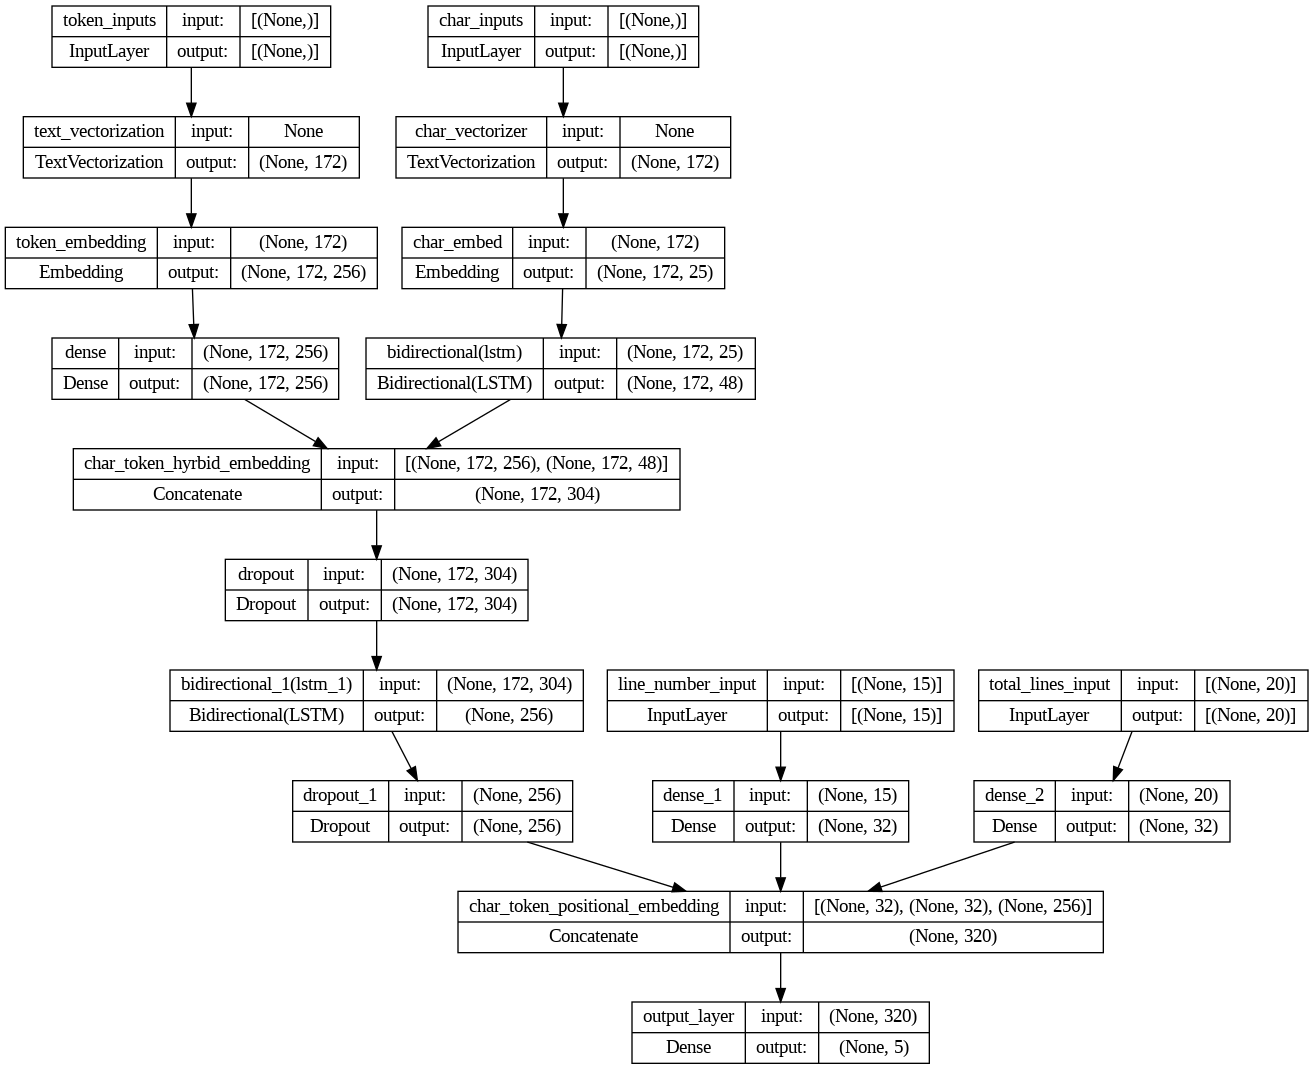

In [ ]:
plot_model(model_6_leaky, show_shapes=True)

In [ ]:
# Compile token, char, and positional embedding model
model_6_leaky.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit our trbrid embedding model
history_model_6_leaky = model_6_leaky.fit(train_char_token_pos_dataset,
                                          steps_per_epoch=int(0.2*len(train_char_token_pos_dataset)),
                                          epochs=5,
                                          validation_data=val_char_token_pos_dataset,
                                          validation_steps=int(0.1*len(val_char_token_pos_dataset))
                                          )

Epoch 1/5
1125/1125 [==============================] - 114s 76ms/step - loss: 0.9927 - accuracy: 0.7927 - val_loss: 0.9122 - val_accuracy: 0.8441
Epoch 2/5
1125/1125 [==============================] - 63s 56ms/step - loss: 0.9093 - accuracy: 0.8497 - val_loss: 0.8968 - val_accuracy: 0.8517
Epoch 3/5
1125/1125 [==============================] - 62s 55ms/step - loss: 0.9028 - accuracy: 0.8558 - val_loss: 0.8813 - val_accuracy: 0.8674
Epoch 4/5
1125/1125 [==============================] - 68s 61ms/step - loss: 0.8890 - accuracy: 0.8620 - val_loss: 0.8679 - val_accuracy: 0.8763
Epoch 5/5
1125/1125 [==============================] - 65s 58ms/step - loss: 0.8855 - accuracy: 0.8659 - val_loss: 0.8746 - val_accuracy: 0.8680


In [ ]:
model_6_leaky.save(MODEL_PATH + 'model_6_leaky')

In [ ]:
model_6_leaky = tf.keras.models.load_model(MODEL_PATH + 'model_6_leaky')

In [ ]:
model_6_leaky_preds = predict_data(model_6_leaky, val_char_token_pos_dataset)
model_6_leaky_results = calculate_results(y_true=le_labels_20k[1],
                                    y_pred=model_6_leaky_preds)
model_6_leaky_results

{'accuracy': 87.03164305573944,
 'precision': 0.8720401392815068,
 'recall': 0.8703164305573944,
 'f1': 0.8676567750214729}

In [ ]:
model_6_preds = predict_data(model_6, val_char_token_pos_dataset)
model_6_results = calculate_results(y_true=le_labels_20k[1],
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 86.82973652853171,
 'precision': 0.8711492705182088,
 'recall': 0.8682973652853171,
 'f1': 0.8654577443552515}

In [ ]:
scores = pd.DataFrame({'model_6': model_6_results,
                         'model_6_leaky': model_6_leaky_results,
                         }, index=['accuracy', 'precision', 'recall', 'f1'])
scores = scores.T
scores

,accuracy,precision,recall,f1
model_6,86.829737,0.871149,0.868297,0.865458
model_6_leaky,87.031643,0.872040,0.870316,0.867657


In [ ]:
scores['accuracy'] = scores['accuracy'] / 100

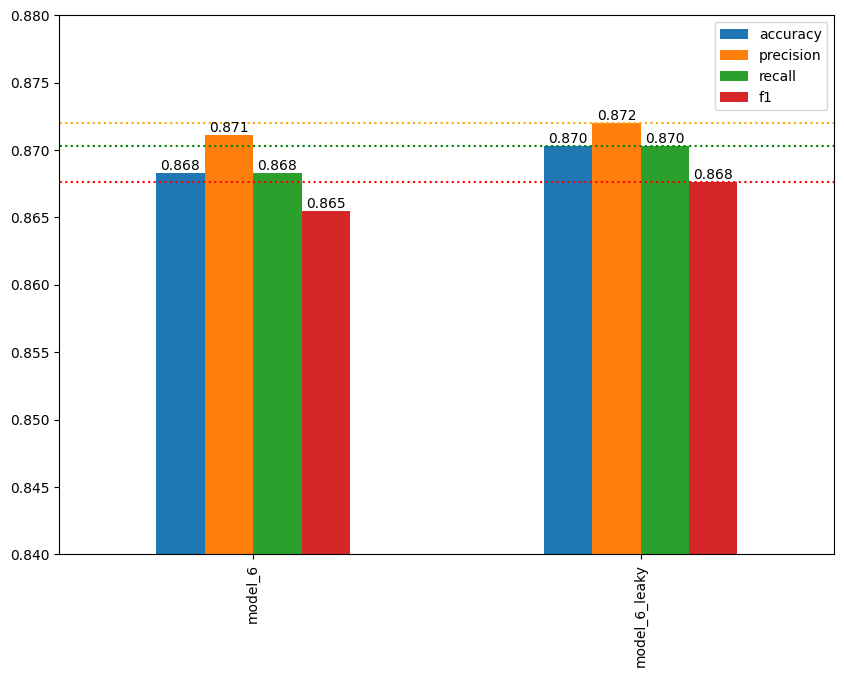

In [ ]:
model_6_leaky_scores = list(model_6_leaky_results.values())
bar = scores.plot(kind="bar", figsize=(10, 7));
color = ['blue', 'orange', 'green', 'red']
plt.ylim([0.84, 0.88])
for i in range(len(scores.columns)):
  bar.bar_label(bar.containers[i], fmt='%.3f')
  plt.hlines(model_6_leaky_scores[i], -10, 10, color=color[i], linestyles='dotted')
plt.show()

It seems that leaky relu has improved all metrics!

## Model 7: Model 6 on full 20k

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=2)

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype='string', name='token_inputs')
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) # create embedding
token_outputs = layers.Dense(256, activation=tf.keras.layers.LeakyReLU())(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), # 15 since each input is one hot encoded into 15 different categories
                                  dtype=tf.float32,
                                  name='line_number_input')

# dense layer with 32 uits and relu activation
x = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(line_number_inputs)

# combine inputs & and ouputs into mdoel
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# 20 since each input is one hot encoded into 20 different categories
y = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hyrbid_embedding')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Bidirectional(layers.LSTM(128))(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
z = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined tokena and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])


# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_7 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_7_tribrid_embedding_model')

In [ ]:
# Compile token, char, and positional embedding model
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit our trbrid embedding model
history_model_7 = model_7.fit(train_char_token_pos_dataset,
                                          steps_per_epoch= len(train_char_token_pos_dataset),
                                          epochs=15,
                                          callbacks=[early_stopping],
                                          validation_data=val_char_token_pos_dataset,
                                          validation_steps=int(0.1*len(val_char_token_pos_dataset))
                                          )

Epoch 1/15
5627/5627 [==============================] - 236s 38ms/step - loss: 0.9178 - accuracy: 0.8442 - val_loss: 0.8752 - val_accuracy: 0.8657
Epoch 2/15
5627/5627 [==============================] - 191s 34ms/step - loss: 0.8497 - accuracy: 0.8908 - val_loss: 0.8830 - val_accuracy: 0.8617
Epoch 3/15
5627/5627 [==============================] - 190s 34ms/step - loss: 0.8129 - accuracy: 0.9180 - val_loss: 0.8894 - val_accuracy: 0.8544


In [ ]:
model_7.save(MODEL_PATH + 'model_7')

In [ ]:
model_7 = tf.keras.models.load_model(MODEL_PATH + 'model_7')

In [ ]:
model_7_preds = predict_data(model_7, val_char_token_pos_dataset)
model_7_results = calculate_results(y_true=le_labels_20k[1],
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 87.04488282801536,
 'precision': 0.8708143089535889,
 'recall': 0.8704488282801536,
 'f1': 0.8675111581805275}

## Model 8: Model 6 with leaky Relu on 200k dataset

Look at notebook 2 for explainations

The final model will be trained on 200k datasets with callbacks

### Preparing Datasets

In [ ]:
# Create training datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_200k[TRAIN],
                                                                total_lines_200k[TRAIN],
                                                                sentences_200k[TRAIN],
                                                                sentences_chars_200k[TRAIN]
                                                                ))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels_200k[TRAIN])
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset_200k = train_char_token_pos_dataset.batch(256).prefetch(tf.data.AUTOTUNE).cache()

# Create validation datasets (with all four kinds of input data)
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_200k[VAL],
                                                              total_lines_200k[VAL],
                                                              sentences_200k[VAL],
                                                              sentences_chars_200k[VAL]
                                                              ))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels_200k[VAL])
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset_200k = val_char_token_pos_dataset.batch(256).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
# from notebook 2
max_tokens = 120000 # paper 1 states that there are 330000 but, keeping it 120000 due to limitations
output_len = 172

### Creating Another Text Vectorization Layer

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                            output_mode='int',
                                            output_sequence_length=output_len)

In [ ]:
# Adapt text vectorizer to training sentences (only 800000 due to limitations)
text_vectorizer.adapt(sentences_200k[TRAIN][:800000])

In [ ]:
rct_200k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_200k_text_vocab)}')
print(f"Most common woords in the vocav: {rct_200k_text_vocab[:5]}")
print(f"Least common woords in the vocav: {rct_200k_text_vocab[:-5]}")

Number of words in vocab: 120000
Most common woords in the vocav: ['', '[UNK]', 'the', 'of', 'and']
Least common woords in the vocav: ['', '[UNK]', 'the', 'of', 'and', 'in', 'to', 'with', 'a', 'were', 'was', 'patients', 'for', 'group', 'p', 'or', 'at', 'treatment', 'on', 'study', 'after', 'by', 'is', 'groups', 'this', 'as', 'that', 'not', 'from', 'no', 'an', 'randomized', 'between', 'significant', 'significantly', 'compared', 'than', 'placebo', 'control', 'be', 'n', 'trial', 'months', 'mg', 'during', 'two', 'had', 'both', 'clinical', 'mean', 'vs', 'there', 'therapy', 'weeks', 'baseline', 'we', 'all', 'intervention', 'effects', 'more', 'pain', 'time', 'who', 'effect', 'years', 'but', 'are', 'using', 'rate', 'days', 'received', 'women', 'subjects', 'total', 'respectively', 'difference', 'levels', 'one', 'efficacy', 'blood', 'ci', 'primary', 'risk', 'increased', 'use', 'higher', 'may', 'day', 'randomly', 'associated', 'differences', 'these', 'used', 'dose', 'either', 'care', 'have', 'week

### Creating Text Embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_200k_text_vocab), # length of our vocabulary
                               output_dim=256,
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

### Creating Character Tokenizer

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (`[UNK]`)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                          output_sequence_length=output_len,
                                          # standardize=None, # set standardization to `None` to include punctuations
                                          name='char_vectorizer'
                                          )

In [ ]:
# Adapt character vectorizer to training character (only 800000 due to limitations)
char_vectorizer.adapt(sentences_chars_200k[TRAIN][:800000])

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating Character-Level Embedding

In [ ]:
PAPER_2_EMBEDDING_CHAR_DIM = 25 # From Paper 2 Figure 1

char_embed = layers.Embedding(input_dim=len(char_vocab), # Number of different characters
                              output_dim=PAPER_2_EMBEDDING_CHAR_DIM,
                              mask_zero=True,
                              name='char_embed'
                              )

### Creating, Compiling, and Fitting Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype='string', name='token_inputs')
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) # create embedding
token_outputs = layers.Dense(256, activation=tf.keras.layers.LeakyReLU())(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), # 15 since each input is one hot encoded into 15 different categories
                                  dtype=tf.float32,
                                  name='line_number_input')

# dense layer with 32 uits and relu activation
x = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(line_number_inputs)

# combine inputs & and ouputs into mdoel
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# 20 since each input is one hot encoded into 20 different categories
y = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hyrbid_embedding')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Bidirectional(layers.LSTM(128))(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
z = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined tokena and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])


# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_8 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='final_model')

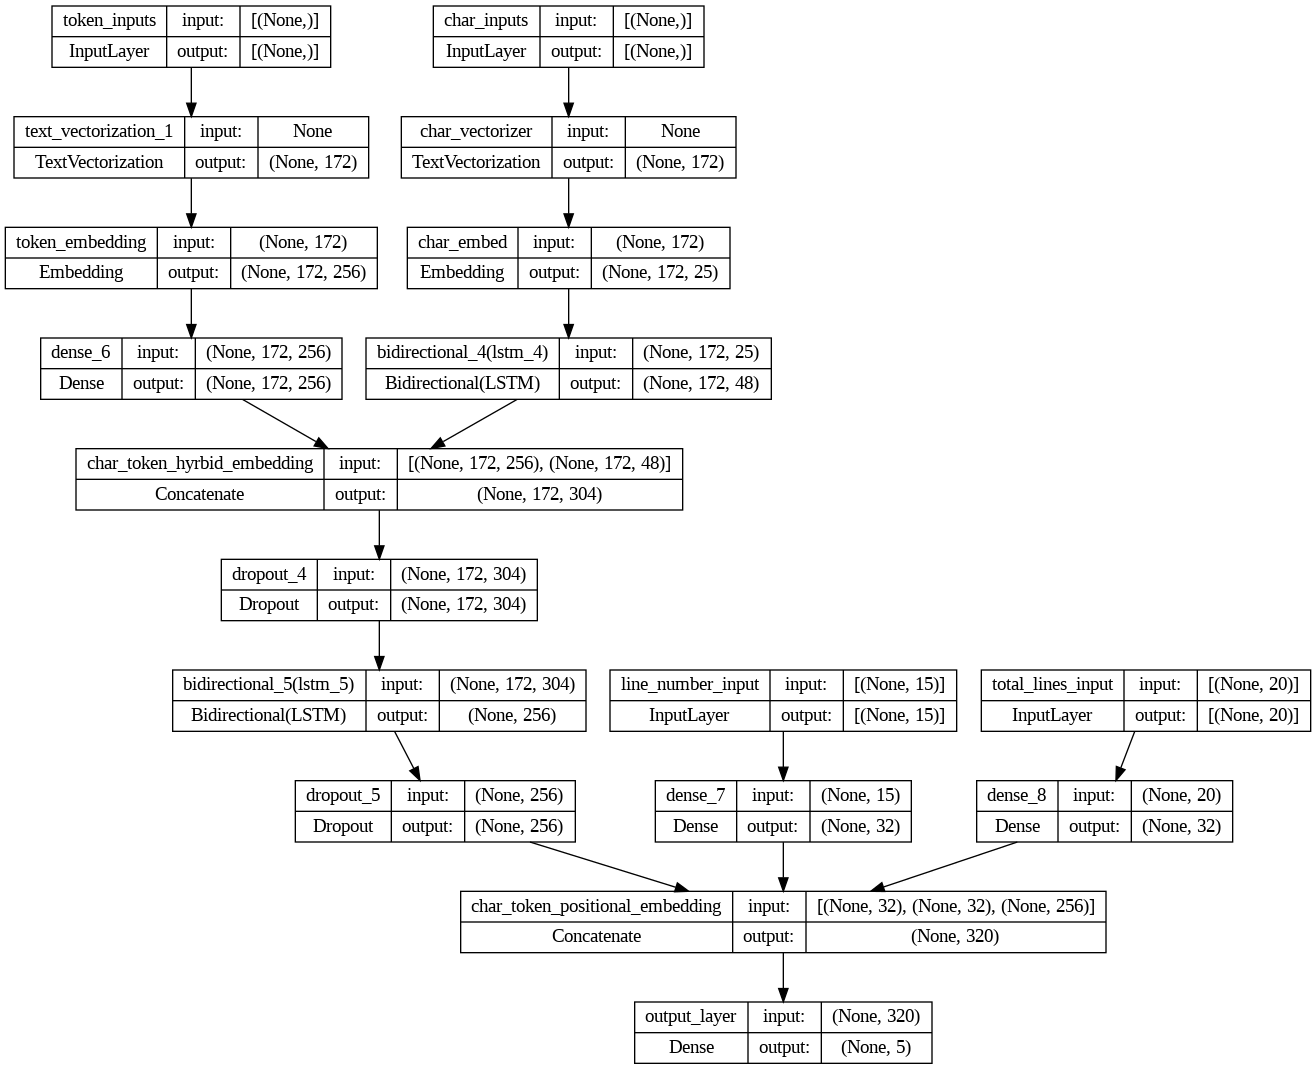

In [ ]:
plot_model(model_8, show_shapes=True)

In [ ]:
# Compile token, char, and positional embedding model
model_8.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit our trbrid embedding model
history_model_8 = model_8.fit(train_char_token_pos_dataset_200k,
                                          steps_per_epoch=int(len(train_char_token_pos_dataset_200k)),
                                          epochs=30,
                                          callbacks= [early_stopping],
                                          validation_data=val_char_token_pos_dataset_200k,
                                          validation_steps=int(0.1*len(val_char_token_pos_dataset_200k))
                                          )

Epoch 1/30
8641/8641 [==============================] - 893s 102ms/step - loss: 0.8663 - accuracy: 0.8746 - val_loss: 0.8361 - val_accuracy: 0.8896
Epoch 2/30
8641/8641 [==============================] - 843s 98ms/step - loss: 0.8371 - accuracy: 0.8935 - val_loss: 0.8299 - val_accuracy: 0.8945
Epoch 3/30
8641/8641 [==============================] - 851s 98ms/step - loss: 0.8245 - accuracy: 0.9029 - val_loss: 0.8321 - val_accuracy: 0.8910
Epoch 4/30
8641/8641 [==============================] - 852s 99ms/step - loss: 0.8133 - accuracy: 0.9116 - val_loss: 0.8396 - val_accuracy: 0.8807


In [ ]:
model_8.save(MODEL_PATH + 'model_8')

In [ ]:
model_8 = tf.keras.models.load_model(MODEL_PATH + 'model_8')

In [ ]:
model_8_preds = predict_data(model_8, val_char_token_pos_dataset_200k)
model_8_results = calculate_results(y_true=le_labels_200k[VAL],
                                    y_pred=model_8_preds)
model_8_results

{'accuracy': 89.38545555094704,
 'precision': 0.8956115788315598,
 'recall': 0.8938545555094705,
 'f1': 0.8927263506108322}